In [91]:
import clip
import torch
from PIL import Image
import numpy as np  
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import h5py
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pickle
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import requests
import io
import shutil

In [92]:
def rgb_to_class_id(mask_path, color_to_class_id):
    
    # Retrieve the data
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    # Initialize the class ID array
    class_ids = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)

    # Map each color to its corresponding class ID
    for color, class_id in color_to_class_id.items():
        # Create a mask for each color
        color_mask = np.all(mask == np.array(color, dtype=np.uint8), axis=-1)
        class_ids[color_mask] = class_id

    return class_ids

In [93]:
def segment_and_save_images(original_img_path, output_path, mask_id, color_to_class_id):
    # Load the original image
    original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
    if original_img is None:
        print("Error loading the original image.")
        return None

    # Resize the mask to match the original image dimensions
    mask_id_resized = cv2.resize(mask_id, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Determine which class IDs are present in the resized mask
    present_classes = np.unique(mask_id_resized)
    

    paths = []
    # Loop through each class ID in the color_to_class_id dictionary
    for color, class_id in color_to_class_id.items():
        if class_id != 0 and class_id in present_classes:  # Skip background and check presence
            
            # Create a blank white image with the same dimensions as the original
            segmented_img = np.ones_like(original_img) * 255  # Set all pixels to white

            # Apply the mask for the current class_id
            mask = mask_id_resized == class_id
            segmented_img[mask] = original_img[mask]

            # Convert BGR to RGB for plotting (optional)
            # segmented_img_rgb = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB)

            # Display the segmented image using matplotlib (optional)
            # plt.figure(figsize=(10, 8))  # Adjust the figure size as necessary
            # plt.imshow(segmented_img_rgb)
            # plt.title(f'Segmented Image for Class ID {class_id}')
            # plt.axis('off')  # Hide the axes
            # plt.show()

            # Save the image to file
            cv2.imwrite(f'{output_path}/s_c_{class_id}.png', segmented_img)
            paths.append((f's_c_{class_id}.png', class_id))
    return paths
    

In [94]:
def generate_combined_embedding(full_image_path, categorical_data, model, preprocess, encoder, device, encoding_vector_length):
    # Process the image
    image = preprocess(Image.open(full_image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image).cpu().numpy()
    
    # One-hot encode the categorical data
    # Ensure categorical_data is in the form of a 2D array [[cat1, cat2, ..., catN]]
    one_hot_features = encoder.transform([categorical_data])
    
    # Combine the image embedding and one-hot features
    combined_embedding = np.concatenate((image_embedding.squeeze(0), one_hot_features.squeeze(0)), axis=0)
    #combined_embedding = np.concatenate((image_embedding.squeeze(0), np.zeros(encoding_vector_length)), axis=0)

    
    return combined_embedding

In [95]:
def find_closest_embedding_cosine(new_embedding, embeddings):
    similarities = np.array([cosine(new_embedding, emb) for emb in embeddings])
    closest_index = np.argmin(similarities)
    return closest_index, similarities[closest_index]

In [96]:
def get_image(idx, links, images):
    image_name = images.loc[idx, 'path']
    row, col = image_name.split('_')[0:2]

    image_url = links.iloc[int(row), int(col)]
    
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            # image = Image.open(io.BytesIO(response.content))
            import matplotlib.pyplot as plt
            # Convert response.content to image
            image = Image.open(io.BytesIO(response.content))

            return image

        else:
            print(f"Failed to download: {image_name}")
            get_image(image_name)  # Retry download
    
    except Exception as e:
        print(f"Error downloading {image_name}: {str(e)}")


In [97]:
def get_image_by_name(image_name, links):
    row, col = image_name.split('_')[0:2]

    image_url = links.iloc[int(row), int(col)]
    
    try:
        response = requests.get(image_url)
        if response.status_code == 200:
            # image = Image.open(io.BytesIO(response.content))
            import matplotlib.pyplot as plt
            # Convert response.content to image
            image = Image.open(io.BytesIO(response.content))

            return image

        else:
            print(f"Failed to download: {image_name}")
            get_image_by_name(image_name, links)  # Retry download
    
    except Exception as e:
        print(f"Error downloading {image_name}: {str(e)}")

In [98]:
def get_nearest_products(new_embedding, train_embeddings, images, num_options=3):

    k = 2 * num_options + 1

    similarities = np.array([cosine(new_embedding, emb) for emb in train_embeddings])
    
    k_lowest_values_indices = np.argsort(similarities)[:k]
    

    viewed_rows = []
    nearest_images = []
    
    i=0
    while len(nearest_images) < num_options:
        idx = k_lowest_values_indices[i]
        if images.loc[idx, 'row'] in viewed_rows:
            i+=1
            continue
        else:
        #check if the image distance with some image in the nearist_images is very close to 0
            if any([np.isclose(cosine(train_embeddings[images[images['path'] == image].index[0]], train_embeddings[idx]), 0, atol=1e-6) for image in nearest_images]):
                i+=1
                continue
            
        nearest_images.append(images.loc[idx, 'path'])
        viewed_rows.append(images.loc[idx, 'row'])
        i+=1
  
    return nearest_images

In [99]:
def show_product_neighbours(product_paths, links):

    fig, axes = plt.subplots(1, len(product_paths), figsize=(15, 5))

    for i, path in enumerate(product_paths):
        axes[i].imshow(get_image_by_name(path, links))
        axes[i].axis('off')

    plt.show()

In [100]:
def get_product_neighbours_images(product_paths, links):

    pictures = []
    for path in product_paths:
        pictures.append(get_image_by_name(path, links))

    return pictures

In [101]:
def push_to_backend(segment_path, output_path, output_path_to_segment,dir_path):
    # Remove if already exists
    # items
    for i in range(2):
        for j in range(3):
            #print(f"{dir_path}/{i}_{j}.jpg")
            if os.path.exists(f"{dir_path}/{i}_{j}.jpg"):
                os.remove(f"{dir_path}/{i}_{j}.jpg")
    # segmasks
    for i in range(2):
        if os.path.exists(f"{dir_path}/s_c_{i+1}.jpg"):
            os.remove(f"{dir_path}/s_c_{i+1}.jpg")
    # mask
    if os.path.exists(f"{output_path_to_segment}/input.jpg"):
            os.remove(f"{output_path_to_segment}/input.jpg")
    
    # Move segmentation data
    # items
    for i in range(2):
        for j in range(3):
            shutil.copy(f"{output_path}/{i}_{j}.jpg", f"{dir_path}/{i}_{j}.jpg")
    # segmasks
    for i in range(2):
        shutil.copy(f"{segment_path}/s_c_{i+1}.png", f"{dir_path}/s_c_{i+1}.jpg")
    # mask
    shutil.copy(f"{output_path_to_segment}/input.png", f"{dir_path}/mask.jpg")
    

In [102]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device} device")

# Load the model
model, preprocess = clip.load('ViT-B/32', device=device)

Using cuda device


In [103]:
# Load the encoder
with open('../ckp/encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

In [104]:
print(loaded_encoder.categories_)

[array(['I', 'S', 'V', 'W'], dtype=object), array([0, 1, 2, 4]), array([1, 2, 3])]


In [105]:
h5pt_file_path = '/home/guimcc/OneDrive/General/Projectes/HackUPC2024/ckp/images_30k_clean.h5'
h5f = h5py.File(h5pt_file_path, 'r')
train_embeddings = h5f['image_embeddings'][:]

In [116]:
images = pd.read_csv('../index/images_resized_30k_clean.csv')

links = pd.read_csv('../inditextech_hackupc_challenge_images.csv')

In [107]:
train_embeddings.shape

(47472, 523)

In [108]:
# Recieve image at
image_path_to_segment = '/home/guimcc/OneDrive/General/Projectes/HackUPC2024/images_to_inference/input'

output_path_to_mask = '/home/guimcc/OneDrive/General/Projectes/HackUPC2024/images_to_inference/output'
output_path_to_segment = '/home/guimcc/OneDrive/General/Projectes/HackUPC2024/images_to_inference/segmented_mask'
output_image_path = '/home/guimcc/OneDrive/General/Projectes/HackUPC2024/images_to_inference/zzz'

website_path = '/home/guimcc/OneDrive/General/Projectes/HackUPC2024/server/static'

In [118]:
# Get the data to predict
# if os.path.exists(f"{image_path_to_segment}/input.png"):
#     os.remove(f"{image_path_to_segment}/input.png")
    
# shutil.copy(f"{website_path}/image_to_predict.jpeg", f"{image_path_to_segment}/input.png")

image_name = os.listdir(image_path_to_segment)[0] # input.png

# Apply the semantic segmentation task
command = "python /home/guimcc/OneDrive/General/Projectes/cloth-segmentation/cloth_segmentation/infer.py"
os.system(command)

joined_path_org = os.path.join(image_path_to_segment, image_name)
joined_path_mask = os.path.join(output_path_to_mask, image_name)

# Apply the semantic segmentation task
color_to_class_id = {
    (0, 0, 0): 0,     # Example: Background
    (128, 0, 0): 1,   # Example: Upper Body Cloth
    (0, 128, 0): 2,   # Example: Lower Body Cloth
    (0, 0, 128): 3     # Example: Full body wear
}

masked_image = rgb_to_class_id( joined_path_mask, color_to_class_id)

saved_images = segment_and_save_images(joined_path_org, output_path_to_segment, masked_image, color_to_class_id)

# Calculate the embeddings

encoding_vector_length = sum(len(categories) for categories in loaded_encoder.categories_)

# zeros_categorical_data = np.zeros(encoding_vector_length)

results = []

for cloth in saved_images:
    new_image_path = os.path.join(output_path_to_segment, cloth[0])
    categorical_data = ['I', 0, 2]
    #catcegorical_data[cloth[1]] = 1
    
    new_embedding = generate_combined_embedding(new_image_path, categorical_data, model, preprocess, loaded_encoder, device, encoding_vector_length)
    
    results.append(get_nearest_products(new_embedding, train_embeddings, images))
    
# Once we have the embeddings, we can search for the image paths
for j, product in enumerate(results):
    print(product)
    #show_product_neighbours(i, links)
    neighbours = get_product_neighbours_images(product, links)
    for i, neighbour in enumerate(neighbours):
        #print("neighbour: ", neighbour)
        neighbour.save(f'{output_image_path}/{j}_{i}.jpg')

# And push everything to backend
push_to_backend(output_path_to_segment, output_image_path, output_path_to_mask, website_path)

----checkpoints loaded from path: /home/guimcc/OneDrive/General/Projectes/cloth-segmentation/checkpoint_u2net.pth----


  0%|          | 0/1 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/torch/nn/functional.py:3782: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


['6031_1_2023_I_0_2', '26760_1_2023_I_0_2', '5819_2_2023_I_0_1']
['8887_2_2023_I_0_2', '30957_1_2024_V_0_1', '34137_2_2023_I_0_1']


In [113]:
for i in results:
    print(i)

['8526_1_2024_V_1_3', '10877_0_2024_V_0_2', '10528_1_2024_V_0_1']
['5787_0_2024_V_1_2', '1374_1_2024_V_0_1', '10042_0_2024_V_0_3']


In [115]:
for j, product in enumerate(results):
    print(product)
    #show_product_neighbours(i, links)
    neighbours = get_product_neighbours_images(product, links)
    for i, neighbour in enumerate(neighbours):
        #print("neighbour: ", neighbour)
        neighbour.save(f'{output_image_path}/{j}_{i}.jpg')

['8526_1_2024_V_1_3', '10877_0_2024_V_0_2', '10528_1_2024_V_0_1']
['5787_0_2024_V_1_2', '1374_1_2024_V_0_1', '10042_0_2024_V_0_3']


Error downloading 8526_1_2024_V_1_3: HTTPSConnectionPool(host='static.zara.net', port=443): Max retries exceeded with url: /photos///2024/V/1/3/p/3212/330/300/2/w/2048/3212330300_6_2_1.jpg?ts=1699953670187 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7d7b18a6bbe0>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))


TypeError: Image data of dtype object cannot be converted to float

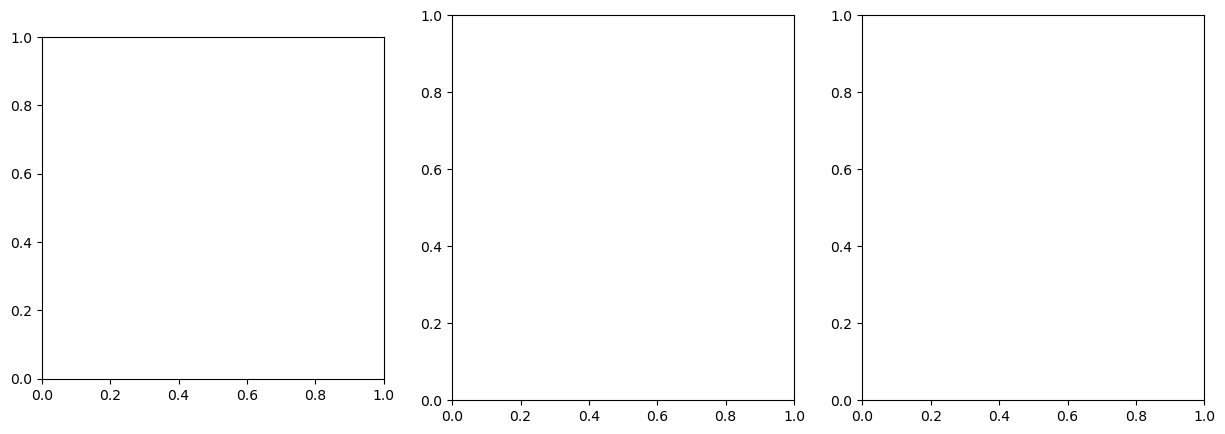

In [114]:
for product in results:
    show_product_neighbours(product, links)


In [ ]:
# Save the images to the output path


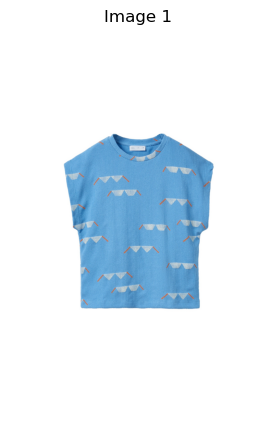

In [ ]:
image_list = [get_image(result[0], links, images) for result in results]


for idx, image in enumerate(image_list):
    plt.figure(figsize=(5, 5))  # Set the figure size as needed
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Image {idx + 1}")  # Optional: add a title to each subplot
    plt.show()